In [1]:
import nipype.pipeline.engine as pe
import nipype.interfaces.io as nio
from nipype.pipeline import Node, MapNode, Workflow
from nipype.interfaces.utility import IdentityInterface, Function
from nipype.interfaces.io import DataSink
from nipype.interfaces.ants import Registration
from nipype.interfaces.ants import ApplyTransforms
import nipype.interfaces.fsl as fsl
import nipype.interfaces.utility as util

180510-11:15:20,503 duecredit ERROR:
	 Failed to import duecredit due to No module named 'duecredit'


In [2]:
import os
data_dir = os.path.abspath('/Volumes/_Research/Intracranial/bids')
ants_output_dir = os.path.join(data_dir, 'derivatives', 'ants')
fsl_output_dir = os.path.join(data_dir, 'derivatives', 'fsl')
ants_data_dir = os.path.join(ants_output_dir, 'template')

# Create output folders structure
if not os.path.exists(os.path.join(data_dir, 'derivatives')):
    os.mkdir(os.path.join(data_dir, 'derivatives'))

if not os.path.exists(ants_output_dir):
    os.mkdir(ants_output_dir)
    
if not os.path.exists(fsl_output_dir):
    os.mkdir(fsl_output_dir)
    
if not os.path.exists(ants_data_dir):
    os.mkdir(ants_data_dir)

Download MNI template

In [26]:
from nilearn.datasets import load_mni152_template,get_data_dirs, fetch_icbm152_2009
from nilearn import plotting
template = fetch_icbm152_2009(data_dir=ants_data_dir)
print(template['t1'])

/Volumes/_Research/Intracranial/bids/derivatives/ants/template/icbm152_2009/mni_icbm152_nlin_sym_09a/mni_icbm152_t1_tal_nlin_sym_09a.nii


In [16]:
bet = pe.Node(interface=fsl.BET(),name='bet')
#bet.inputs.reduce_bias = True
bet.inputs.surfaces = True
bet.inputs.mesh = True
bet.inputs.frac = 0.7
bet.inputs.output_type = 'NIFTI_GZ'

# coregistration step based on affine transformation using ANTs
coreg = pe.Node(Registration(), name='CoregAnts')
coreg.inputs.output_transform_prefix = 'func2highres'
coreg.inputs.output_warped_image = 'func2highres.nii.gz'
coreg.inputs.output_transform_prefix = "func2highres_"
coreg.inputs.transforms = ['Rigid', 'Affine']
coreg.inputs.transform_parameters = [(0.1,), (0.1,)]
coreg.inputs.number_of_iterations = [[100, 100]]*3 
coreg.inputs.dimension = 3
coreg.inputs.write_composite_transform = True
coreg.inputs.collapse_output_transforms = False
coreg.inputs.metric = ['Mattes'] * 2 
coreg.inputs.metric_weight = [1] * 2 
coreg.inputs.radius_or_number_of_bins = [32] * 2 
coreg.inputs.sampling_strategy = ['Regular'] * 2 
coreg.inputs.sampling_percentage = [0.3] * 2 
coreg.inputs.convergence_threshold = [1.e-8] * 2 
coreg.inputs.convergence_window_size = [20] * 2
coreg.inputs.smoothing_sigmas = [[4, 2]] * 2 
coreg.inputs.sigma_units = ['vox'] * 4
coreg.inputs.shrink_factors = [[6, 4]] + [[3, 2]]
coreg.inputs.use_estimate_learning_rate_once = [True] * 2
coreg.inputs.use_histogram_matching = [False] * 2 
coreg.inputs.initial_moving_transform_com = True

# registration or normalization step based on symmetric diffeomorphic image registration (SyN) using ANTs 
reg = pe.Node(Registration(), name='NormalizationAnts')
reg.inputs.output_transform_prefix = 'highres2template'
reg.inputs.output_warped_image = 'highres2template.nii.gz'
reg.inputs.output_transform_prefix = "highres2template_"
reg.inputs.transforms = ['Rigid', 'Affine', 'SyN']
reg.inputs.transform_parameters = [(0.1,), (0.1,), (0.2, 3.0, 0.0)]
reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 2 + [[40, 10, 5]])
#reg.inputs.number_of_iterations = ([[10000, 111110, 11110]] * 2 + [[100, 60, 35]])
reg.inputs.dimension = 3
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = True
reg.inputs.initial_moving_transform_com = True
reg.inputs.metric = ['Mattes'] * 2 + [['Mattes', 'CC']]
reg.inputs.metric_weight = [1] * 2 + [[0.5, 0.5]]
reg.inputs.radius_or_number_of_bins = [32] * 2 + [[32, 4]]
reg.inputs.sampling_strategy = ['Regular'] * 2 + [[None, None]]
reg.inputs.sampling_percentage = [0.3] * 2 + [[None, None]]
reg.inputs.convergence_threshold = [1.e-8] * 2 + [-0.01]
reg.inputs.convergence_window_size = [20] * 2 + [5]
reg.inputs.smoothing_sigmas = [[4, 2, 1]] * 2 + [[1, 0.5, 0]]
reg.inputs.sigma_units = ['vox'] * 3
reg.inputs.shrink_factors = [[3, 2, 1]]*2 + [[4, 2, 1]]
reg.inputs.use_estimate_learning_rate_once = [True] * 3
reg.inputs.use_histogram_matching = [False] * 2 + [True]
reg.inputs.winsorize_lower_quantile = 0.005
reg.inputs.winsorize_upper_quantile = 0.995
# reg.inputs.output_warped_image = 'output/ants/registration/output_warped_image.nii.gz'
#reg.inputs.output_transform_prefix = 'output/ants/registration/'
reg.inputs.num_threads = 2 # 4
reg.inputs.args = '--float'
reg.inputs.fixed_image = template['t1']

In [37]:
reg = pe.Node(Registration(), name='NormalizationAnts')
reg.inputs.fixed_image = template['t1']
#reg.inputs.moving_image = 'output/ants/brainextraction/BrainExtractionBrain.nii.gz' #'sub-10_T1w.nii.gz'
reg.inputs.output_transform_prefix = "output/ants/registration/output_"
#reg.inputs.initial_moving_transform = 'trans.mat'
reg.inputs.transforms = ['Affine', 'SyN']
reg.inputs.transform_parameters = [(2.0,), (0.25, 3.0, 0.0)]
reg.inputs.number_of_iterations = [[1500, 200], [100, 50, 30]]
reg.inputs.dimension = 3
reg.inputs.write_composite_transform = True
reg.inputs.collapse_output_transforms = False
reg.inputs.initialize_transforms_per_stage = False
reg.inputs.metric = ['Mattes']*2
reg.inputs.metric_weight = [1]*2 # Default (value ignored currently by ANTs)
reg.inputs.radius_or_number_of_bins = [32]*2
reg.inputs.sampling_strategy = ['Random', None]
reg.inputs.sampling_percentage = [0.05, None]
reg.inputs.convergence_threshold = [1.e-8, 1.e-9]
reg.inputs.convergence_window_size = [20]*2
reg.inputs.smoothing_sigmas = [[1,0], [2,1,0]]
reg.inputs.sigma_units = ['vox'] * 2
reg.inputs.shrink_factors = [[2,1], [3,2,1]]
reg.inputs.use_estimate_learning_rate_once = [True, True]
reg.inputs.use_histogram_matching = [True, True] # This is the default
reg.inputs.output_warped_image = 'output/ants/registration/output_warped_image.nii.gz'
reg.inputs.output_transform_prefix = 'output/ants/registration/'
reg.inputs.num_threads = 2 # 4

In [38]:
regworkflow = pe.Workflow('intracranial-ants-mni')    
#regworkflow.connect(BIDSDataGrabber, "anat_filenames", Separator, "input_full_path")
#regworkflow.connect(Separator, 'freesurfer_subj_id', recon_all, 'subject_id')
#regworkflow.connect(Separator, 'filename', bet, 'in_file')
#regworkflow.connect(Separator, 'freesurfer_output_path', recon_all, 'subjects_dir')

regworkflow.connect(bet, 'out_file', reg, 'moving_image')
# regworkflow.connect(bet,'out_file', coreg, 'fixed_image')
#regworkflow.connect(reg, 'warped_image',outputnode, 'registered_T1')



In [39]:
from bids.grabbids import BIDSLayout
    
layout = BIDSLayout(data_dir)
anats = [f.filename for f in layout.get(modality="anat", type='T1w', extensions=['nii', 'nii.gz'])]

print(anats)

for a in anats:
    subject = a.split('/')[5]
    
    fsl_subject_output_dir = fsl_output_dir+'/'+subject
    ants_subject_output_dir = ants_output_dir+'/'+subject+'/'
    
    if not os.path.exists(fsl_subject_output_dir):
        os.mkdir(fsl_subject_output_dir)
    
    if not os.path.exists(ants_subject_output_dir):
        os.mkdir(ants_subject_output_dir)
    
    
    
    bet.inputs.in_file = a
    bet.inputs.out_file = fsl_subject_output_dir+'/bet.nii.gz'
    
    reg.inputs.output_transform_prefix = ants_subject_output_dir
    reg.inputs.output_warped_image = os.path.join(ants_subject_output_dir,'output_warped_image.nii.gz')
    
    regworkflow.run()
#regworkflow.run("MultiProc", plugin_args={'n_procs': 4})

/Users/tgurgui/anaconda3/envs/jupyter_brain_env/lib/python3.6/site-packages/grabbit/core.py:410: UserWarning: No valid root directory found for domain 'derivatives'. Falling back on the Layout's root directory. If this isn't the intended behavior, make sure the config file for this domain includes a 'root' key.
  "'root' key." % config['name'])


['/Volumes/_Research/Intracranial/bids/sub-01/anat/sub-01_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-02/anat/sub-02_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-03/anat/sub-03_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-04/anat/sub-04_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-05/anat/sub-05_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-06/anat/sub-06_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-07/anat/sub-07_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-08/anat/sub-08_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-09/anat/sub-09_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-10/anat/sub-10_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-11/anat/sub-11_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-12/anat/sub-12_T1w.nii.gz', '/Volumes/_Research/Intracranial/bids/sub-mni/anat/sub-mni_T1w.nii']
180511-15:33:57,585 workflow INFO:
	 Workflow intracranial-ants-mni settings: ['check', 'e

RuntimeError: Workflow did not execute cleanly. Check log for details

In [22]:
print(ants_output_dir)

/Volumes/_Research/Intracranial/bids/derivatives/ants


In [29]:
at1 = ApplyTransforms()
at1.inputs.dimension = 3
at1.inputs.input_image = os.path.join(fsl_output_dir, 'sub-01', 'bet.nii.gz') #anats[0]
at1.inputs.reference_image = template['t1']
at1.inputs.output_image = os.path.join(ants_output_dir, 'sub-01', 'deformed_moving.nii.gz')
at1.inputs.interpolation = 'BSpline'
at1.inputs.interpolation_parameters = (5,)
at1.inputs.default_value = 0
at1.inputs.transforms = os.path.join(ants_output_dir, 'sub-01', 'Composite.h5')
at1.inputs.invert_transform_flags = False
at1.cmdline
res = at1.run()
print(res.outputs)


output_image = /Volumes/_Research/Intracranial/bids/derivatives/ants/sub-01/deformed_moving.nii.gz



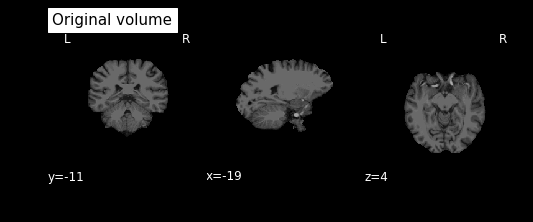

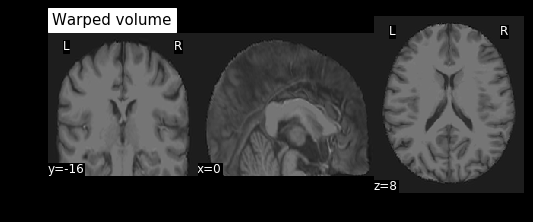

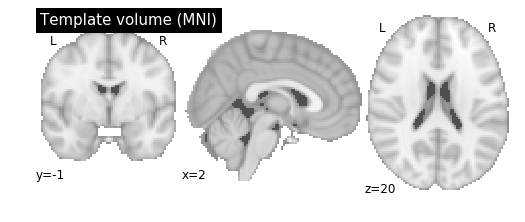

In [33]:
plotting.plot_anat(os.path.join(fsl_output_dir, 'sub-01', 'bet.nii.gz'), \#anats[0], \
                  title = "Original volume", \
                  draw_cross=False)
plotting.plot_anat(os.path.join(ants_output_dir, 'sub-01', 'deformed_moving.nii.gz'), \
                  title = "Warped volume", \
                  draw_cross=False)
plotting.plot_anat(title = "Template volume (MNI)", \
                  draw_cross=False)